In [1]:
# Import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

In [2]:
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [3]:
# Import the train set and test set
train_data = pd.read_csv("normalized_train_dataset_dis.csv", delimiter=",")
test_data = pd.read_csv("normalized_test_dataset_dis.csv", delimiter=",")

In [4]:
#train_data = train_data.drop('DataArpu', axis=1)
train_data = train_data.drop('ID', axis=1)
# Sort the dataset
train_data = train_data.iloc[np.random.permutation(len(train_data))]
train_data = train_data.reset_index(drop=True)

In [5]:
array = np.asarray(train_data)

X = array[:,0:train_data.shape[1]-1]
X = np.asarray(X)
Y = array[:,train_data.shape[1]-1]
Y = np.asarray(Y)

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi2_test = SelectKBest(score_func=chi2, k=27)
fit = chi2_test.fit(X,Y)

In [7]:
train_data.columns[chi2_test.get_support(indices=True)]

Index(['DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount',
       'MonthlyDataTraffic', 'CustomerGender', 'CustomerExpatriate', 'ZipCode',
       'ChurnScore', 'AirportConnectionsDuration', 'AirportConnectionsCount',
       'StationConnectionsDuration', 'StationConnectionsCount',
       'ParkingConnectionsDuration', 'ParkingConnectionsCount',
       'File-Transfer', 'Instant-Messaging-Applications', 'Mail',
       'Music-Streaming', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Web-Applications', 'Region', 'Province',
       'CustomerAge'],
      dtype='object')

In [12]:
# summarize scores
np.set_printoptions(precision=1)
print(fit.scores_)
#features = fit.transform(X)

[2.4e+01 3.2e+00 2.6e+01 1.4e+01 8.7e+00 4.8e-01 8.1e+00 9.7e+01 3.1e+01
 2.0e+06 2.2e+00 3.4e+01 3.5e+01 3.9e+01 3.5e+01 6.4e+01 6.5e+01 1.1e+01
 1.3e-01 3.6e+00 2.2e+00 9.4e+00 2.3e-01 5.7e+00 3.0e+00 2.5e+00 2.0e+00
 8.8e-01 4.5e-01 6.9e+00 7.0e+01 2.1e+02 7.5e+01]


In [13]:
def features_labels_split(data):
    
    features = data[train_data.columns[chi2_test.get_support(indices=True)]]
    labels = data['Product']
    return features, labels

In [14]:
def train_test_validation_split(features, labels, val_samples, test_samples):

    features = np.asarray(features)
    labels =np.asarray(labels)
    
    X_test = features[0:test_samples]
    y_test = labels[0:test_samples]

    X_val = features[test_samples:test_samples + val_samples]
    y_val = labels[test_samples:test_samples + val_samples]

    X_train = features[test_samples + val_samples:]
    y_train = labels[test_samples + val_samples:]

    return X_train, X_test, X_val, y_train, y_test, y_val

In [17]:
train_feat, train_label = features_labels_split(train_data)

num_val_samples = 0
num_test_samples = 950
X_train, X_test, X_val, y_train, y_test, y_val = train_test_validation_split(train_feat, train_label, num_val_samples, num_test_samples)

In [18]:
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

In [30]:
# Build the default models to select the best one  
# The commented classifiers are weak
dtc = DecisionTreeClassifier()
bnb = BernoulliNB()
xtc = ExtraTreesClassifier()
nb = GaussianNB()
qda = QuadraticDiscriminantAnalysis()
lr = LogisticRegression()
lda = LinearDiscriminantAnalysis()
ada = AdaBoostClassifier()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
gbc = GradientBoostingClassifier()
#gpc = GaussianProcessClassifier() #Too fucking slow
perc = Perceptron()
paggr = PassiveAggressiveClassifier()
svc = SVC()
lsvc = LinearSVC()
sgd = SGDClassifier()
xgb = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.09, n_jobs=-1)


# Append all the models into an array
models = []
models.append(('XGB', xgb))
#models.append(('SGD', sgd))
#models.append(('SVC', svc))
#models.append(('LSVC', lsvc))
#models.append(('PAGGR', paggr))
#models.append(('PERC', perc))
#models.append(('LR', lr))
#models.append(('LDA', lda))
#models.append(('KNN', knn))
#models.append(('DTC', dtc))
#models.append(('NB', nb))
#models.append(('GBC', gbc))
models.append(('RF', rf))
#models.append(('ADA', ada))
#models.append(('QDA', qda))
#models.append(('BNB', bnb))
#models.append(('XTC', xtc))


XGB: 0.587 (0.019)
RF: 0.562 (0.017)


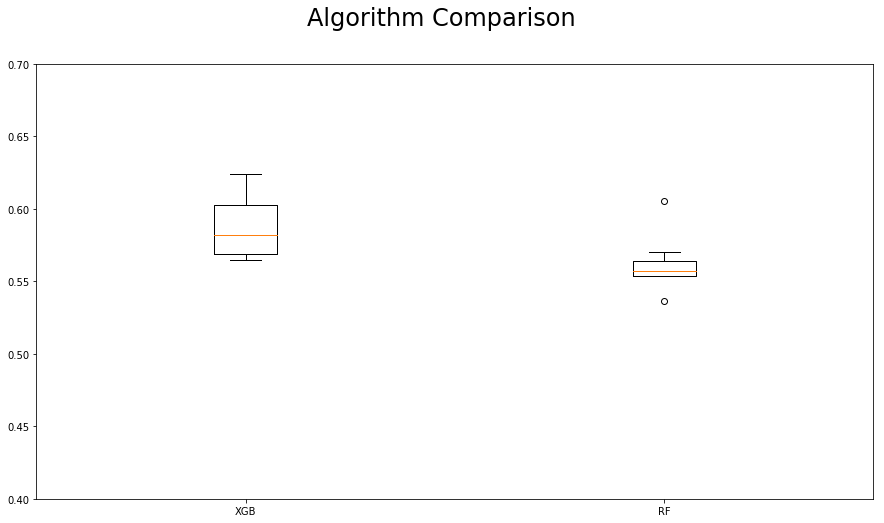

In [31]:
from sklearn.model_selection import cross_val_score


# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_micro', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
plt.ylim([0.40,0.70])
ax.set_xticklabels(names)
plt.show()

## Computing best features
Before starting the tuning phase, we chose the best number of features for each classifier and we plotted the best (mean) performances that we could observe performing a complete exploration of all the possibilities.

Model: NB, Avg_Score: 0.555, Num_Feat: 2
Model: RF, Avg_Score: 0.561, Num_Feat: 23


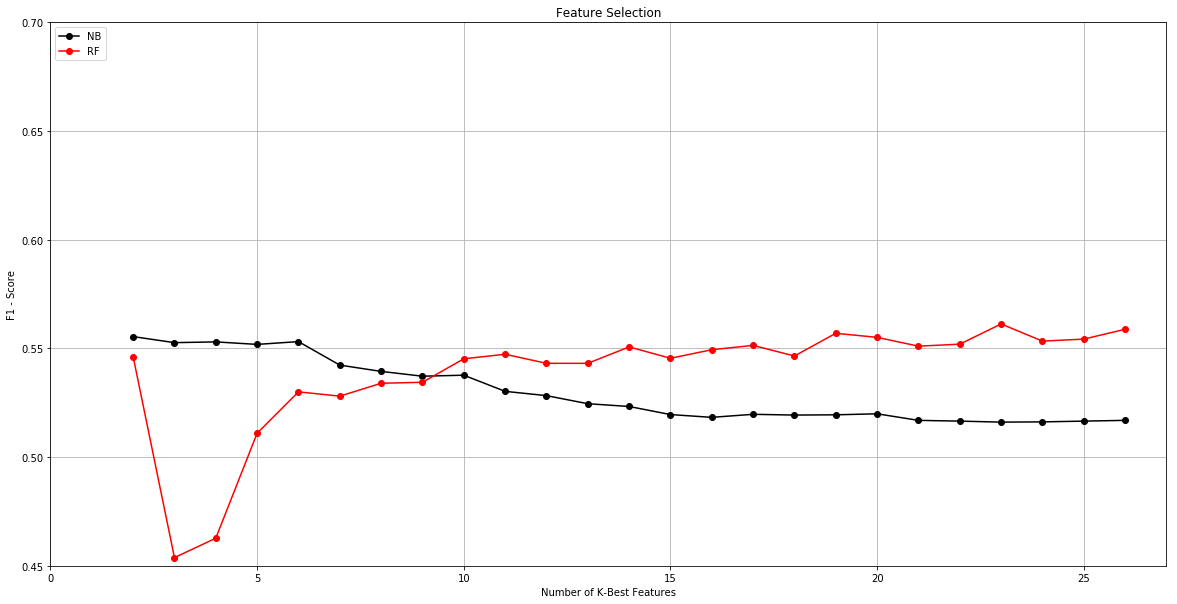

In [32]:
models = []
# models.append(('LR', lr, 'Yellow'))
#models.append(('LDA', lda, 'Blue'))
# models.append(('KNN', knn, 'Green'))
models.append(('NB', nb, 'Black'))
# models.append(('GBC', gbc, 'Orange'))
models.append(('RF', rf, 'Red'))
# models.append(('ADA', ada, 'Grey'))
# models.append(('QDA', qda, 'Purple'))
#models.append(('XGB', xgb, 'Cyan'))
#models.append(('XTC', xtc, 'Magenta'))

feat_range = X_train.shape[1]

n = ['NB','XGB']
n_number = np.arange(2,feat_range,1)
# Transforming the lists into array for plotting
plt.figure(figsize=(20, 10))
plt.title('Feature Selection')
plt.xlabel("Number of K-Best Features")
plt.ylabel("F1 - Score")
plt.grid()

num_feat_arr = []
for name, model, c in models:
    
    scores = [0, 0]
    results = []

    for n in range(2,feat_range):

        selection = SelectKBest(k=n).fit(X_train,y_train)
        X_k = selection.transform(X_train)
        
        
        # Feature Scaling
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        X_k = sc.fit_transform(X_k)
        
        score = cross_val_score(estimator = model, X = X_k, y = y_train, cv = 10, scoring='f1_micro')
        f1 = score.mean()
        
        results.append(f1)
        
        std = score.std()
        if scores[0] < f1:
            scores = [f1, n]
  
    plt.plot(n_number, results, 'o-', color=c, label=name)
    
    num_feat_arr.append(scores[1])
    max_avg = np.average(scores)
    
    print("Model: %s, Avg_Score: %.3f, Num_Feat: %d" % (name, scores[0], scores[1]))  


plt.axis([0, feat_range , 0.45, 0.70])
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.show()

In [26]:
from sklearn.model_selection import GridSearchCV

classifier = XGBClassifier(n_jobs=-1, n_estimators=200)

n_estimators = np.arange(100,1000,100)
max_depth = np.arange(2,5,1)
learning_rate = np.arange(0.05,0.15,0.02)

parameters = [{
    'learning_rate':learning_rate
               }]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring='f1_micro',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)
best_f1 = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_f1)
print(best_parameters)

0.5831495880236741
{'learning_rate': 0.09000000000000001}


In [38]:
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier(n_estimators=400)

n_estimators = (150,400,50)
max_features = ('auto','sqrt','log2',None)
criterion = ('gini','entropy')
parameters = [{
    'criterion':criterion,
               }]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring='f1_micro',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)
best_f1 = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_f1)
print(best_parameters)

0.585470581408843
{'criterion': 'gini'}


In [39]:
# Test Performance

test_model = RandomForestClassifier(n_estimators=400)
test_model.fit(X_train, y_train)
y_pred = test_model.predict(X_test)
# F1
print("F1 score on unseen data: %.3f" % f1_score(y_test, y_pred, average='micro'))

F1 score on unseen data: 0.596


In [40]:
X_pred = test_data[train_data.columns[chi2_test.get_support(indices=True)]]

In [41]:
classifier = RandomForestClassifier(n_estimators=400)
classifier.fit(train_feat, train_label)
y_pred = classifier.predict(X_pred)

In [42]:
submit = test_data['ID']
submit = pd.DataFrame({'ID': submit})

pred = y_pred
pred = pd.DataFrame({'Product': y_pred})

product = []
product = pred.Product
product.replace({ 
    int(0) : 'Non-Customer', 
    int(1) : 'V-Bag', 
    int(2) : 'V-Pet', 
    int(3) : 'V-Auto'},
    inplace=True)

submit = submit.join(product)
submit.to_csv('result.csv', index = False, encoding='utf-8')

In [43]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


In [44]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [45]:
from keras.utils.np_utils import to_categorical

categorical_labels = to_categorical(4, num_classes=None)

In [129]:
neurons = 16
batch_size = 512         
epochs = 500
output_size = 4
loss = 'sparse_categorical_crossentropy'
learning_rate = 0.0001
optimizer= Adam(learning_rate)

hidden_layer_activation = 'tanh'

# Build a simple network
neural_network = Sequential()
neural_network.add(Dense(neurons, input_shape=(X_train.shape[1],),activation=hidden_layer_activation))
neural_network.add(Dropout(0.25))
neural_network.add(Dense(neurons, activation=hidden_layer_activation))
neural_network.add(Dense(neurons, activation=hidden_layer_activation))
neural_network.add(Dropout(0.25))
neural_network.add(Dense(units=output_size, activation=('softmax')))
# Compile the network
neural_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
neural_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 16)                448       
_________________________________________________________________
dropout_52 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_139 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_140 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_53 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 4)                 68        
Total params: 1,060
Trainable params: 1,060
Non-trainable params: 0
_________________________________________________________________


In [130]:
neural_network.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=batch_size)

Train on 8617 samples, validate on 950 samples
Epoch 1/500
8617/8617 [==============================] - 2s 226us/step - loss: 1.4505 - acc: 0.2475 - val_loss: 1.3152 - val_acc: 0.1737
Epoch 2/500
8617/8617 [==============================] - 0s 24us/step - loss: 1.4223 - acc: 0.2709 - val_loss: 1.2868 - val_acc: 0.1789
Epoch 3/500
8617/8617 [==============================] - 0s 24us/step - loss: 1.3933 - acc: 0.2970 - val_loss: 1.2615 - val_acc: 0.1811
Epoch 4/500
8617/8617 [==============================] - 0s 25us/step - loss: 1.3656 - acc: 0.3245 - val_loss: 1.2394 - val_acc: 0.5716
Epoch 5/500
8617/8617 [==============================] - 0s 24us/step - loss: 1.3583 - acc: 0.3446 - val_loss: 1.2200 - val_acc: 0.5726
Epoch 6/500
8617/8617 [==============================] - 0s 24us/step - loss: 1.3357 - acc: 0.3745 - val_loss: 1.2037 - val_acc: 0.5726
Epoch 7/500
8617/8617 [==============================] - 0s 24us/step - loss: 1.3120 - acc: 0.4032 - val_loss: 1.1895 - val_acc: 0.5737


8617/8617 [==============================] - 0s 26us/step - loss: 1.1944 - acc: 0.5494 - val_loss: 1.1323 - val_acc: 0.5737
Epoch 61/500
8617/8617 [==============================] - 0s 24us/step - loss: 1.1931 - acc: 0.5497 - val_loss: 1.1324 - val_acc: 0.5737
Epoch 62/500
8617/8617 [==============================] - 0s 23us/step - loss: 1.1911 - acc: 0.5495 - val_loss: 1.1324 - val_acc: 0.5737
Epoch 63/500
8617/8617 [==============================] - 0s 24us/step - loss: 1.1904 - acc: 0.5501 - val_loss: 1.1324 - val_acc: 0.5737
Epoch 64/500
8617/8617 [==============================] - 0s 25us/step - loss: 1.1881 - acc: 0.5518 - val_loss: 1.1325 - val_acc: 0.5737
Epoch 65/500
8617/8617 [==============================] - 0s 24us/step - loss: 1.1856 - acc: 0.5530 - val_loss: 1.1326 - val_acc: 0.5737
Epoch 66/500
8617/8617 [==============================] - 0s 24us/step - loss: 1.1934 - acc: 0.5538 - val_loss: 1.1326 - val_acc: 0.5737
Epoch 67/500
8617/8617 [==============================

KeyboardInterrupt: 